# Introduction to Deep Learning: Final Project

For the final project, you will identify a Deep Learning problem to perform EDA and model analysis.  This should show a Deep Learning problem description, EDA procedure, analysis (model building and training), result, and discussion/conclusion. 

# Deep Learning problem description

The goal of this project is to classify whether images contain either a dog or a cat, using the Kaggle dataset found at https://www.kaggle.com/competitions/dogs-vs-cats, which was originally provided by Microsoft Research.

This dataset contains 25,000 images of dogs and cats, which are correctly labelled (1 = dog, 0 = cat).

This type of image classification is well suited to Convolutional Neural Network (CNN) models, which to a good job of extracting visual features from images. 

# Imports

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import zipfile
import cv2 # Computer Vision library
import matplotlib.pyplot as plt

# Tensorflow.keras neural network objects
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D



# Dataset Import

The 25,000 images files are provided in the form of 1 zipped files "train.zip", so these need to be unzipped and placed into a folder '/kaggle/working/train'. 

In [6]:
# Read in training zip file, and extract all files to "/kaggle/working/train"
trn_zip=zipfile.ZipFile("/kaggle/input/dogs-vs-cats/train.zip","r")
trn_zip.extractall()

In [7]:
path = '/kaggle/working/train'
print("Number of extracted training images: ",len(os.listdir(path)))

Number of extracted training images:  25000


Inspect the first 10 image filenames. Note the image classification is encoded inthe filenames, dog*.jpg and cat*.jpg

In [8]:
for dirname, _, filenames in os.walk(path):
    for filename in filenames[:10]:
        print(os.path.join(dirname, filename))

/kaggle/working/train/dog.9007.jpg
/kaggle/working/train/cat.10011.jpg
/kaggle/working/train/dog.12303.jpg
/kaggle/working/train/dog.4487.jpg
/kaggle/working/train/dog.4985.jpg
/kaggle/working/train/dog.6840.jpg
/kaggle/working/train/cat.7778.jpg
/kaggle/working/train/dog.8103.jpg
/kaggle/working/train/cat.5745.jpg
/kaggle/working/train/cat.4487.jpg


# EDA procedure

First, lets use the cv2 "imread" method to read the jpg images from file and convert to grayscale. Then perform an initial inspection of the first 16 images.

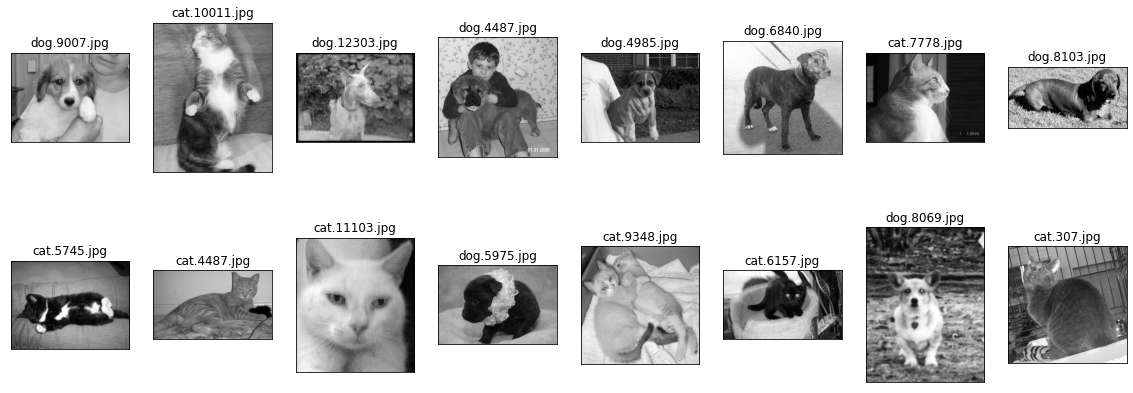

In [9]:
fig, axs = plt.subplots(2, 8, figsize=(20,7))
axs = axs.ravel()
for (i,p) in enumerate(os.listdir(path)[:16]):
    img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
    axs[i].imshow(img_array,cmap="gray")
    axs[i].set_title(p)
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)

These images look reasonably good, however they are all of different dimensions. This will be a problem for the CNN later on, as it expects the input data to be of fixed length.

To find an "ideal" new size for the images is a bit of an trial and error process. If the images are rescaled too large and , then the input data to the CNN will be uncessarily large and slow down the training time. If the images are rescaled too small, the loss of pixels may cause the CNN to fail because the images do not contain enough definition.

Let's try a few sizes until it looks about right ...

Display the first 8 images in a variety of sizes, then choose the smallest image size that does not have any significant visual loss of reoslution.

Images rescaled to  25 x 25


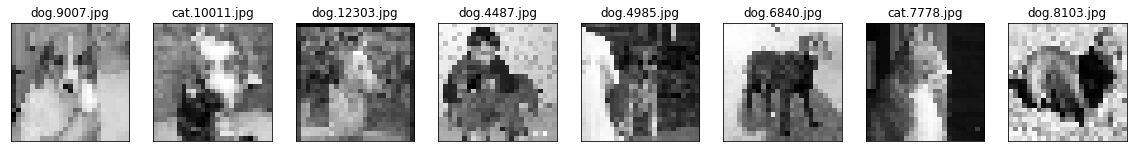

Images rescaled to  50 x 50


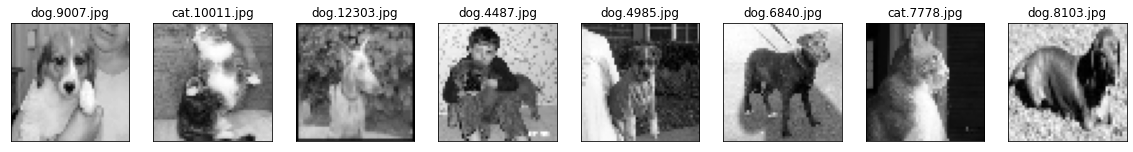

Images rescaled to  75 x 75


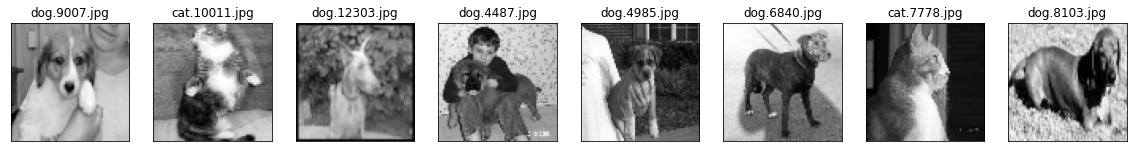

Images rescaled to  100 x 100


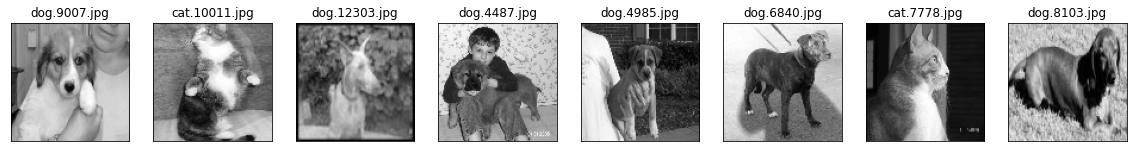

Images rescaled to  200 x 200


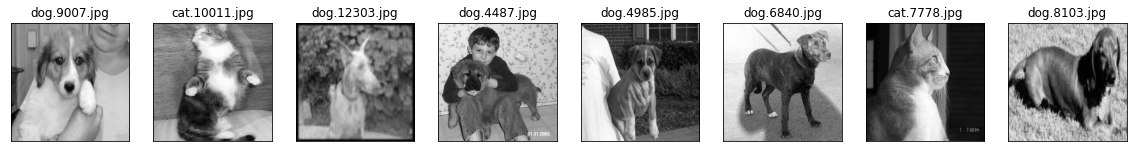

In [10]:
def print_images(size):
    print("Images rescaled to ",size,"x",size);
    fig, axs = plt.subplots(1, 8, figsize=(20,7))
    axs = axs.ravel()

    for (i,p) in enumerate(os.listdir(path)[:8]):
        img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(size, size))
        axs[i].imshow(new_img_array,cmap="gray")
        axs[i].set_title(p)
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)
    plt.show();

print_images(25)
print_images(50)
print_images(75)
print_images(100)
print_images(200)

From the above, looks like an image size of 100x100 will be about right.

However the rescaling has caused distortion in some of the images due to the change in aspect ratio. 

The two options for dealing with this are either to pad the smaller dimension of the smaller images with black pixels, or crop the larger images to fit the common smaller size.  Given that using pads to correct the aspect ratio which usually is very bad when you are trying to create standardized datasets for a neural network, we will instead crop the images to the desired size:



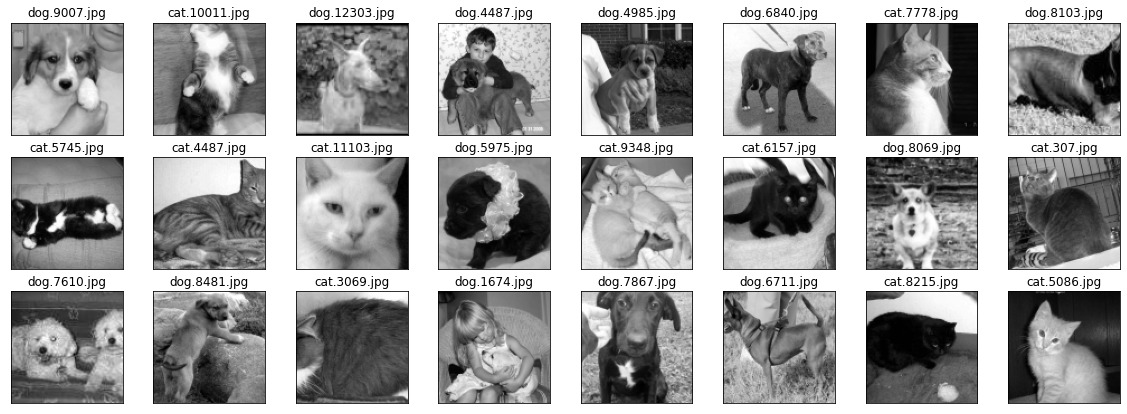

In [14]:
def crop_square(img, size, interpolation=cv2.INTER_AREA):
    h, w = img.shape[:2]
    min_size = np.amin([h,w])

    # Centralize and crop
    crop_img = img[int(h/2-min_size/2):int(h/2+min_size/2), int(w/2-min_size/2):int(w/2+min_size/2)]
    resized = cv2.resize(crop_img, (size, size), interpolation=interpolation)

    return resized

fig, axs = plt.subplots(3, 8, figsize=(20,7))
axs = axs.ravel()

for (i,p) in enumerate(os.listdir(path)[:24]):
    img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
    new_img_array=crop_square(img_array, 100)
    axs[i].imshow(new_img_array,cmap="gray")
    axs[i].set_title(p)
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
plt.show();

As is obvious from the above samples, the centering of the cropping has sometimes cropped the head of the animal, however given the large amount of training data and the fact that even the cropped image contains features for that animal, this is not forseen to be a problem.

Now lets read the images into array X and the class variable into array Y:

In [21]:
X = []
y = []

for p in os.listdir(path):   
    img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
    new_img_array=crop_square(img_array, 100)
    X.append(new_img_array)
    category = p.split(".")[0] # "cat", "dog"
    y.append(1 if category == 'dog' else 0)

Now transform X and y into numpy arrays and reshape X.

In [31]:
X = np.array(X).reshape(-1, 100,100,1)
y = np.array(y)

Check the first 20 y (class) values are as expected

In [24]:
y[:20]

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1])

In [32]:
X.shape


(25000, 100, 100, 1)

The final step is to normalise all of the image values to fall within the range of 0 to 1, rather than 0 to 255. Although not strictly neccesary, this is help the CNN to train more easily.

In [27]:
X = X/255.0

## Class balance

Lets check that there is a reasonably even balance between the class labels of 'cat' and 'dog'

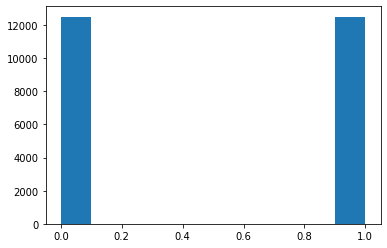

In [29]:
plt.hist(y);

That looks like an even 50/50 split! Perfect :-)

# Develop CNN Models

Now we come to the meaty part- defining the CNN network, the engine of our application. 

The CNNs have several different filters/kernels consisting of trainable parameters which can convolve on a given image spatially to detect features like edges and shapes. These high number of filters essentially learn to capture spatial features from the image based on the learned weights through back propagation and stacked layers of filters can be used to detect complex spatial shapes from the spatial features at every subsequent level. Hence they can successfully boil down a given image into a highly abstracted representation which is easy for predicting.The CNNs have several different filters/kernels consisting of trainable parameters which can convolve on a given image spatially to detect features like edges and shapes. These high number of filters essentially learn to capture spatial features from the image based on the learned weights through back propagation and stacked layers of filters can be used to detect complex spatial shapes from the spatial features at every subsequent level. Hence they can successfully boil down a given image into a highly abstracted representation which is easy for predicting.

For each model we are going to define a series of Convolution Layers, and each convolution layer consists of a convolution operation followed by a max pool layer. The max pooling layer downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.

This order is not mandatory- you can have two Convolution operations followed by one max pool, or three, or an average pool- that's the neat part of neural networks, they're so adaptable and malleable, and the best configurations are often found out by trial and error. 


## Model 1

Lets start with a reasonably standard 

In [49]:
model1 = Sequential()

# Add an Convolutional layer with 64 filters and a 3x3 kernel size, matching the input image siaze of 100x100
model1.add(Conv2D(64,(3,3), activation = 'relu', input_shape = X.shape[1:]))
model1.add(MaxPooling2D(pool_size = (2,2)))

# Add an Convolutional layer with 64 filters and a 3x3 kernel size
model1.add(Conv2D(64,(3,3), activation = 'relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))

# Add a regular densely connect neural network layer with 64 units
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))

# Add a softmax layer with a binary output (0=cat, 1=dog)
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer="adam", loss='binary_crossentropy',  metrics=['accuracy'])
print(model1.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 98, 98, 64)        640       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 33856)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2166848   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [39]:
history1= model1.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

2023-01-18 22:00:54.898260: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
625/625 [==============================] - 171s 272ms/step - loss: 0.6461 - accuracy: 0.6196 - val_loss: 0.5831 - val_accuracy: 0.6988
Epoch 2/10
625/625 [==============================] - 175s 280ms/step - loss: 0.5368 - accuracy: 0.7330 - val_loss: 0.5172 - val_accuracy: 0.7464
Epoch 3/10
625/625 [==============================] - 170s 272ms/step - loss: 0.4436 - accuracy: 0.7944 - val_loss: 0.5185 - val_accuracy: 0.7444
Epoch 4/10
625/625 [==============================] - 170s 272ms/step - loss: 0.3551 - accuracy: 0.8393 - val_loss: 0.4982 - val_accuracy: 0.7666
Epoch 5/10
625/625 [==============================] - 172s 276ms/step - loss: 0.2406 - accuracy: 0.9022 - val_loss: 0.5783 - val_accuracy: 0.7688
Epoch 6/10
625/625 [==============================] - 175s 281ms/step - loss: 0.1295 - accuracy: 0.9527 - val_loss: 0.6892 - val_accuracy: 0.7646
Epoch 7/10
625/625 [==============================] - 170s 272ms/step - loss: 0.0553 - accuracy: 0.9836 - val_loss: 0.9041 -

In [60]:
# list all data in history
print(history1.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


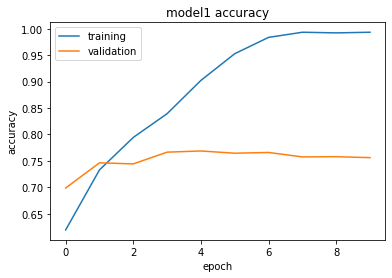

In [61]:
# plot history for training and validation model accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

From the plot above, it is clear that after 2 epochs, the model 1 validation accuracy flattens out at around 75%, whereas the training accuracy ramps up to nearly 100% as it overfits.

## Model 2

Model 1 validation accuracy of 75% is not that great, but at least a starting point.

Lets add another CNN layer.

In [62]:
model2 = Sequential()

# Add an Convolutional layer with 64 filters and a 3x3 kernel size, matching the input image siaze of 100x100
model2.add(Conv2D(64,(3,3), activation = 'relu', input_shape = X.shape[1:]))
model2.add(MaxPooling2D(pool_size = (2,2)))

# Add an Convolutional layer with 64 filters and a 3x3 kernel size
model2.add(Conv2D(64,(3,3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))

# Add an Convolutional layer with 64 filters and a 3x3 kernel size
model2.add(Conv2D(64,(3,3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size = (2,2)))
           
# Add a regular densely connect neural network layer with 64 units
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))

# Add a softmax layer with a binary output (0=cat, 1=dog)
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer="adam", loss='binary_crossentropy',  metrics=['accuracy'])
print(model2.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 98, 98, 64)        640       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 47, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 6400)            

In [63]:
history2= model2.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 188s 300ms/step - loss: 0.6492 - accuracy: 0.6051 - val_loss: 0.5691 - val_accuracy: 0.7084
Epoch 2/10
625/625 [==============================] - 187s 299ms/step - loss: 0.5284 - accuracy: 0.7386 - val_loss: 0.5257 - val_accuracy: 0.7398
Epoch 3/10
625/625 [==============================] - 186s 297ms/step - loss: 0.4516 - accuracy: 0.7869 - val_loss: 0.4663 - val_accuracy: 0.7786
Epoch 4/10
625/625 [==============================] - 184s 294ms/step - loss: 0.3984 - accuracy: 0.8205 - val_loss: 0.4396 - val_accuracy: 0.7940
Epoch 5/10
625/625 [==============================] - 184s 295ms/step - loss: 0.3418 - accuracy: 0.8469 - val_loss: 0.4287 - val_accuracy: 0.8092
Epoch 6/10
625/625 [==============================] - 183s 293ms/step - loss: 0.2934 - accuracy: 0.8733 - val_loss: 0.4297 - val_accuracy: 0.8142
Epoch 7/10
625/625 [==============================] - 183s 293ms/step - loss: 0.2375 - accuracy: 0.8974 - val_loss: 0.4540 -

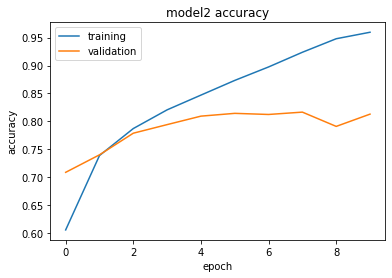

In [64]:
# plot history for training and validation model accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

A little bit better, with validation accuracy of model 2 at around 80# after 2 epochs, and peaking to 84% at epoch 5. Not too bad.

## Model 3

lets add yet another CNN layer

In [65]:
model3 = Sequential()

# Add an Convolutional layer with 64 filters and a 3x3 kernel size, matching the input image siaze of 100x100
model3.add(Conv2D(64,(3,3), activation = 'relu', input_shape = X.shape[1:]))
model3.add(MaxPooling2D(pool_size = (2,2)))

# Add an Convolutional layer with 64 filters and a 3x3 kernel size
model3.add(Conv2D(64,(3,3), activation = 'relu'))
model3.add(MaxPooling2D(pool_size = (2,2)))

# Add an Convolutional layer with 64 filters and a 3x3 kernel size
model3.add(Conv2D(64,(3,3), activation = 'relu'))
model3.add(MaxPooling2D(pool_size = (2,2)))

# Add an Convolutional layer with 64 filters and a 3x3 kernel size
model3.add(Conv2D(64,(3,3), activation = 'relu'))
model3.add(MaxPooling2D(pool_size = (2,2)))
           
# Add a regular densely connect neural network layer with 64 units
model3.add(Flatten())
model3.add(Dense(64, activation='relu'))

# Add a softmax layer with a binary output (0=cat, 1=dog)
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer="adam", loss='binary_crossentropy',  metrics=['accuracy'])
print(model3.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 98, 98, 64)        640       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 47, 47, 64)        36928     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 8, 8, 64)        

In [66]:
history3= model3.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 188s 299ms/step - loss: 0.6719 - accuracy: 0.5779 - val_loss: 0.6221 - val_accuracy: 0.6644
Epoch 2/10
625/625 [==============================] - 186s 297ms/step - loss: 0.5748 - accuracy: 0.7036 - val_loss: 0.5186 - val_accuracy: 0.7412
Epoch 3/10
625/625 [==============================] - 188s 301ms/step - loss: 0.4865 - accuracy: 0.7659 - val_loss: 0.5165 - val_accuracy: 0.7506
Epoch 4/10
625/625 [==============================] - 185s 296ms/step - loss: 0.4224 - accuracy: 0.8058 - val_loss: 0.4423 - val_accuracy: 0.8002
Epoch 5/10
625/625 [==============================] - 185s 296ms/step - loss: 0.3762 - accuracy: 0.8289 - val_loss: 0.3972 - val_accuracy: 0.8198
Epoch 6/10
625/625 [==============================] - 188s 302ms/step - loss: 0.3342 - accuracy: 0.8521 - val_loss: 0.3986 - val_accuracy: 0.8242
Epoch 7/10
625/625 [==============================] - 186s 298ms/step - loss: 0.2966 - accuracy: 0.8709 - val_loss: 0.3837 -

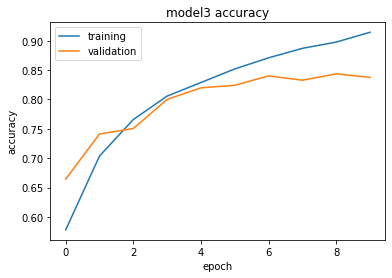

In [67]:
# plot history for training and validation model accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

## Model 4

Let's keep the same number of CNN layers as model 3, but double their number of filters from 64 to 128

In [68]:
model4 = Sequential()

# Add an Convolutional layer with 64 filters and a 3x3 kernel size, matching the input image siaze of 100x100
model4.add(Conv2D(64,(3,3), activation = 'relu', input_shape = X.shape[1:]))
model4.add(MaxPooling2D(pool_size = (2,2)))

# Add an Convolutional layer with 128 filters and a 3x3 kernel size
model4.add(Conv2D(128,(3,3), activation = 'relu'))
model4.add(MaxPooling2D(pool_size = (2,2)))

# Add an Convolutional layer with 128 filters and a 3x3 kernel size
model4.add(Conv2D(128,(3,3), activation = 'relu'))
model4.add(MaxPooling2D(pool_size = (2,2)))

# Add an Convolutional layer with 128 filters and a 3x3 kernel size
model4.add(Conv2D(128,(3,3), activation = 'relu'))
model4.add(MaxPooling2D(pool_size = (2,2)))
           
# Add a regular densely connect neural network layer with 64 units
model4.add(Flatten())
model4.add(Dense(64, activation='relu'))

# Add a softmax layer with a binary output (0=cat, 1=dog)
model4.add(Dense(1, activation='sigmoid'))

model4.compile(optimizer="adam", loss='binary_crossentropy',  metrics=['accuracy'])
print(model4.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 98, 98, 64)        640       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 47, 47, 128)       73856     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 21, 21, 128)       147584    
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 8, 8, 128)       

In [69]:
history4= model4.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 352s 563ms/step - loss: 0.6535 - accuracy: 0.6077 - val_loss: 0.5790 - val_accuracy: 0.7018
Epoch 2/10
625/625 [==============================] - 353s 564ms/step - loss: 0.5206 - accuracy: 0.7474 - val_loss: 0.4538 - val_accuracy: 0.7894
Epoch 3/10
625/625 [==============================] - 351s 561ms/step - loss: 0.4123 - accuracy: 0.8105 - val_loss: 0.4539 - val_accuracy: 0.7888
Epoch 4/10
625/625 [==============================] - 351s 561ms/step - loss: 0.3390 - accuracy: 0.8513 - val_loss: 0.3526 - val_accuracy: 0.8442
Epoch 5/10
625/625 [==============================] - 351s 561ms/step - loss: 0.2807 - accuracy: 0.8794 - val_loss: 0.3873 - val_accuracy: 0.8286
Epoch 6/10
625/625 [==============================] - 357s 571ms/step - loss: 0.2324 - accuracy: 0.9038 - val_loss: 0.3126 - val_accuracy: 0.8674
Epoch 7/10
625/625 [==============================] - 392s 627ms/step - loss: 0.1894 - accuracy: 0.9215 - val_loss: 0.3284 -

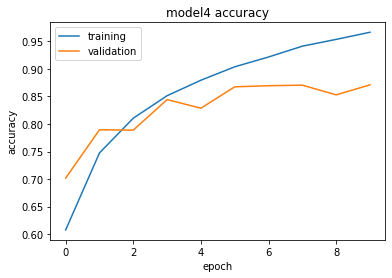

In [70]:
# plot history for training and validation model accuracy
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model4 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

## Model 5

Finally, let's take model 1 and remove the max pooling layers (this will GREATLY increase the size of the model!)

In [71]:
model5 = Sequential()

# Add an Convolutional layer with 64 filters and a 3x3 kernel size, matching the input image siaze of 100x100
model5.add(Conv2D(64,(3,3), activation = 'relu', input_shape = X.shape[1:]))
#model5.add(MaxPooling2D(pool_size = (2,2)))

# Add an Convolutional layer with 64 filters and a 3x3 kernel size
model5.add(Conv2D(64,(3,3), activation = 'relu'))
#model5.add(MaxPooling2D(pool_size = (2,2)))

# Add a regular densely connect neural network layer with 64 units
model5.add(Flatten())
model5.add(Dense(64, activation='relu'))

# Add a softmax layer with a binary output (0=cat, 1=dog)
model5.add(Dense(1, activation='sigmoid'))

model5.compile(optimizer="adam", loss='binary_crossentropy',  metrics=['accuracy'])
print(model5.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 98, 98, 64)        640       
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 96, 96, 64)        36928     
_________________________________________________________________
flatten_12 (Flatten)         (None, 589824)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                37748800  
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 37,786,433
Trainable params: 37,786,433
Non-trainable params: 0
_________________________________________________________________
None


In [72]:
history5= model5.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 669s 1s/step - loss: 0.7309 - accuracy: 0.5603 - val_loss: 0.6491 - val_accuracy: 0.6278
Epoch 2/10
625/625 [==============================] - 640s 1s/step - loss: 0.6095 - accuracy: 0.6750 - val_loss: 0.6081 - val_accuracy: 0.6732
Epoch 3/10
625/625 [==============================] - 623s 997ms/step - loss: 0.4824 - accuracy: 0.7718 - val_loss: 0.6279 - val_accuracy: 0.6884
Epoch 4/10
625/625 [==============================] - 622s 995ms/step - loss: 0.2886 - accuracy: 0.8789 - val_loss: 0.7687 - val_accuracy: 0.6752
Epoch 5/10
625/625 [==============================] - 613s 981ms/step - loss: 0.0938 - accuracy: 0.9679 - val_loss: 1.2383 - val_accuracy: 0.6684
Epoch 6/10
625/625 [==============================] - 622s 995ms/step - loss: 0.0237 - accuracy: 0.9939 - val_loss: 1.6994 - val_accuracy: 0.6672
Epoch 7/10
625/625 [==============================] - 624s 999ms/step - loss: 0.0204 - accuracy: 0.9955 - val_loss: 2.2083 - val_a

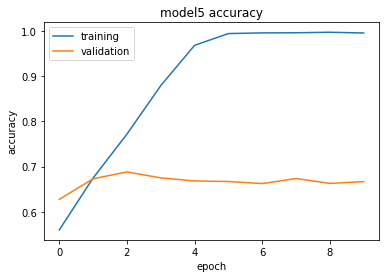

In [73]:
# plot history for training and validation model accuracy
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model5 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

# Summary/Conclusion

Five different CNN models were trained on the 100x100 images, each with slightly different architectures and differing numbers of trainable parameters.

The validation accuracy of each model is shown below:


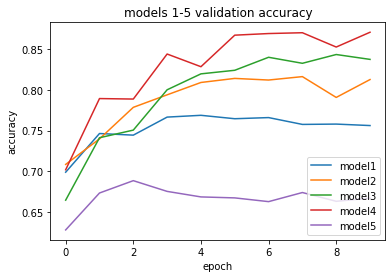

In [76]:
# plot history of validation accuracy for all 5 models
plt.plot(model1_history['val_accuracy'])
plt.plot(model2_history['val_accuracy'])
plt.plot(model3_history['val_accuracy'])
plt.plot(model4_history['val_accuracy'])
plt.plot(model5_history['val_accuracy'])

plt.title('models 1-5 validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['model1', 'model2','model3','model4','model5'], loc='lower right')
plt.show()

In [81]:
model_summary_trainableParameters=[2204481,484225,177089,500865,37786433]
model_summary_bestValidationAccuracy=[77,81,84,87,69]

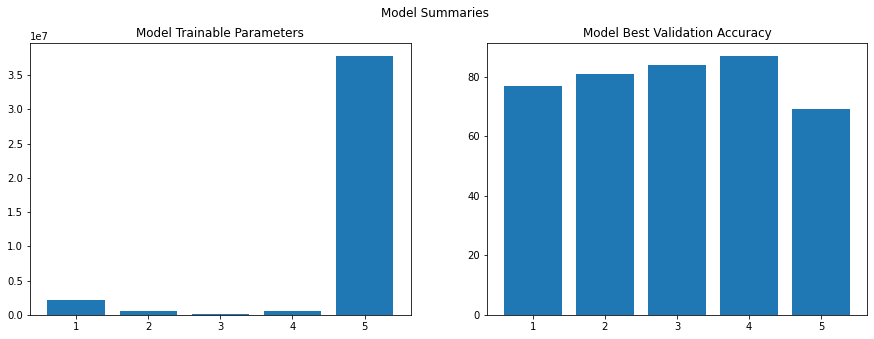

In [96]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Model Summaries')
ax[0].bar([1,2,3,4,5], model_summary_trainableParameters)
ax[0].set_title('Model Trainable Parameters')

ax[1].bar([1,2,3,4,5], model_summary_bestValidationAccuracy)
ax[1].set_title('Model Best Validation Accuracy');

The charts above make it very clear that just because a model is complex (in this case, has very many trainable parameters) does not mean it will be a lot better than models with fewer trainable parameters!

There are an almost infinite number of ways the various layers and layer widths can be configured for a CNN type NN, and no agreed method for how to find the best architecture for a given input set.

One school of thought is: The basic principle followed in building a convolutional neural network is to ‘keep the feature space wide and shallow in the initial stages of the network, and the make it narrower and deeper towards the end.’ However, these are plenty of other AI practitioners who would dispute this, and argue for other approaches. 

The problem of finding an optimal architecture is made even harder because the model training times can be very high. For this project, the 5 models take around 5 hours to run. This is not very condusive to experimentation!

Overall, a validation accuracy of 87% from model 4 is not too shabby, and demonstrates the amazing flexibility and power of the CNN in image classification tasks.